## CAS739 Workshop 5: Evolutionary Strategies
Evolutionary Strategies (ES) are a class of evolutionary algorithms first developed in the 1960s. They are noteable for their statistical recombination of the population to inform the next generation. ES are most often used for **continuous optimization** problems.

Some recent developments in ES include:

Daan Wierstra, Tom Schaul, Tobias Glasmachers, Yi Sun, Jan Peters, & Jürgen Schmidhuber (2014). Natural Evolution Strategies. Journal of Machine Learning Research, 15(27), 949–980. [pdf](https://jmlr.org/papers/volume15/wierstra14a/wierstra14a.pdf)

Tim Salimans, Jonathan Ho, Xi Chen, Szymon Sidor, and Ilya Sutskever. 2017. Evolution Strategies as a Scalable Alternative to Reinforcement Learning. [pdf](https://arxiv.org/abs/1703.03864)




In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import matplotlib.colors as colors
import numpy as np
import math

# A simple $(1 + \lambda)$ ES

The simplest Evolutionary Strategy is the $(1+1)$ ES. In this algorithm, the best individual generated is replaced by a new individual when its **fitness** is superior to the current best. For continuous optimization, we can use a representation of floating point numbers which are modified at each step using a Normal distribution:

    Initialize x randomly in ℝ
    while not terminate
        x' = x + 𝑁(0, σ)
        if f(x′) < f(x)
            x = x'
    return x

Evolutionary Strategies are commonly used for continuous optimization. We will use standard [test functions for continuous optimization](https://en.wikipedia.org/wiki/Test_functions_for_optimization), namely the Himmelblau and Rosenbrock functions. They are defined as follows:

Himmelblau: $f(x,y) = (x^2+y-11)^2 + (x+y^2-7)^2$

Rosenbrock: $f(x) = \sum_{i=1}^{n-1}(B(x_{i+1}-x_i^2)^2+(a-x_i)^2)$

In [2]:
def himmelblau(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

In [3]:
def rosenbrock(x, y, a=1, B=100):
      return (a-x)**2 + B*((y-x**2))**2

We can visualize these functions for a better understanding of the search space.

In [4]:
X = np.arange(-5, 5, 0.1)
Y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(X, Y)
Z = himmelblau(X, Y)
#Z = rosenbrock(X, Y)

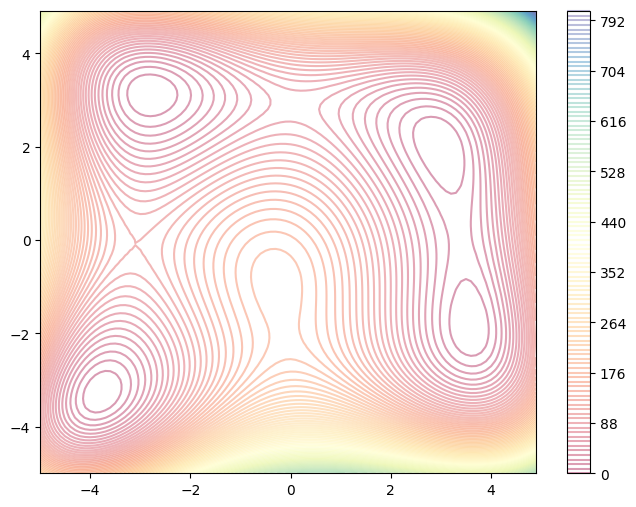

In [5]:
fig = plt.figure(figsize=(8, 6))
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral',
                 norm=colors.Normalize(vmin=Z.min(), vmax=Z.max()), alpha=0.4)
fig.colorbar(cs)
plt.show()

For the (1+1) ES, we start with a random point $x$ and then sample one point around it using a Normal distribution.|

position:  [0.39050803 1.72151493] fitness : 96.57609560795147
new position:  [0.68412943 2.39378289] new fitness : 66.57305350505946


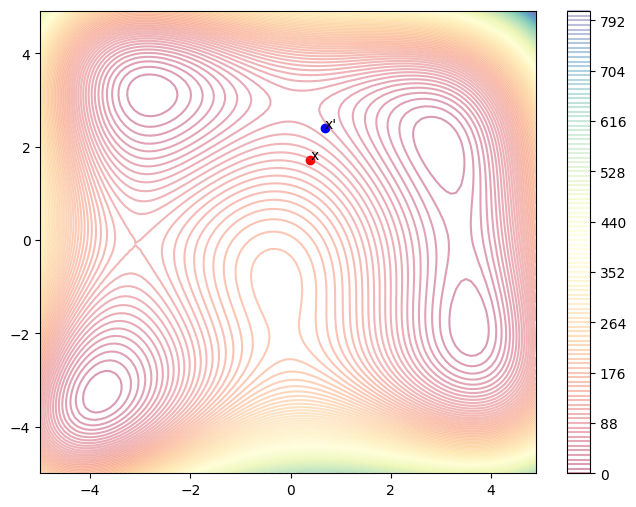

In [6]:
np.random.seed(0)
x = np.random.rand(2) * 8 - 4
x_orig = np.copy(x)
print("position: ", x, "fitness :", himmelblau(x[0], x[1]))
σ = 0.3
x_t = np.random.randn(2)*σ + x
print("new position: ", x_t, "new fitness :", himmelblau(x_t[0], x_t[1]))
fig = plt.figure(figsize=(8, 6))
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', norm=colors.Normalize(vmin=Z.min(), vmax=Z.max()), alpha=0.4)
plt.annotate('x\'', (x_t))
plt.scatter(x_t[0], x_t[1], c='b')
plt.annotate('x', (x))
plt.scatter(x[0], x[1], c='r')
fig.colorbar(cs);

While this greedy algorithm could allow us to move around the search space and eventually find an optimum, we can use multiple samples of this distribution to better inform the movement in the search space. We therefore instead sample multiple points following a Normal distribution around $x$:

In [7]:
x = np.copy(x_orig)
print("position: ", x, "fitness :", himmelblau(x[0], x[1]))
x_t = np.array([x + np.random.normal(size=(2,))*σ for i in range(20)])
x_best = x
fit_best = himmelblau(x[0], x[1])
for i in range(20):
    f = himmelblau(x_t[i, 0], x_t[i, 1])
    if f < fit_best:
        fit_best = f
        x_best = x_t[i, 0], x_t[i, 1]
print("best position: ", x_best, "best fitness :", fit_best)

position:  [0.39050803 1.72151493] fitness : 96.57609560795147
best position:  (0.8503417957261352, 2.1623225619494413) best fitness : 68.01940562226753


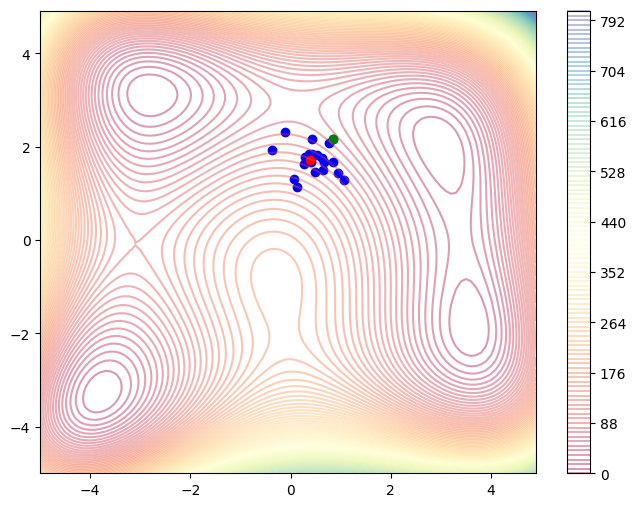

In [8]:
fig = plt.figure(figsize=(8, 6))
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', norm=colors.Normalize(vmin=Z.min(), vmax=Z.max()), alpha=0.4)
plt.scatter(x_t[:, 0], x_t[:, 1], c='b')
plt.scatter(x[0], x[1], c='r')
plt.scatter(x_best[0], x_best[1], c='g')
fig.colorbar(cs);

Having this population of points will enable us to explore the space around $x$ before moving on to the next step. However, these points might overlap or cover spaces that have already been explored. Generating too many points could slow down search, requiring more evaluations of the objective function. In many applications, that is costly.

Performing random optimization but sampling more than 1 point leads to the $(1+\lambda)$ Evolutionary Strategy. 

    Initialize x randomly in ℝ
    x_best = x
    while not terminate
        for i in [1,λ]
            x_i = x + 𝑁(0, σ)
            if f(x_i) < f(x_best)
                x_best = x_i
        x = x_best
    return x_best

In the scope of evolutionary algorithms, we'll refer to $x$ as a parent and all $x'$ points as offspring. Each point can also be referred to as an individual in a population, and $f(x)$ is called the fitness of the individual. Each iteration of the algorithm is called a generation.

<div class="alert alert-info">

The $(\mu/\rho,\lambda)$ or $(\mu/\rho+\lambda)$ notation signifies the configuration of parents and offspring. In this notation, $\mu$ is the number of parents, $\rho$ is the number of parents involved in creating the offspring, and $\lambda$ is the number of offspring. $(\mu/\rho+\lambda)$ means the parents can be included in the next population, whereas $(\mu/\rho,\lambda)$ means the parents are not included. $(1+\lambda)$ therefore means that 1 parent is involved in creating a population of $\lambda$ offspring and can be included in the next generation (ie, if $f(x) < f(x') \forall x'$, $x$ does not change).
    
</div>

In [9]:
def oneplus_lambda(x, fitness, gens=100, lam=20):
    x_best = x
    f_best = fitness(x)
    fits = np.zeros(gens)
    for g in range(gens):
        N = np.random.normal(size=(lam, len(x)))
        for i in range(lam):
            ind = x + N[i, :]
            f = fitness(ind)
            if f < f_best:
                f_best = f
                x_best = ind
        x = x_best
        fits[g] = f_best
    return fits

Let's run the $(1+\lambda)$ ES on the himmelblau function and record the evolution over multiple trials.

In [10]:
f = lambda x : himmelblau(x[0], x[1])
reps = []
for i in range(5):
    x = np.random.rand(2)*10-5
    reps += [oneplus_lambda(x, f)]
reps = np.array(reps)
reps_mean = np.mean(reps, 0)
reps_std = np.std(reps, 0)

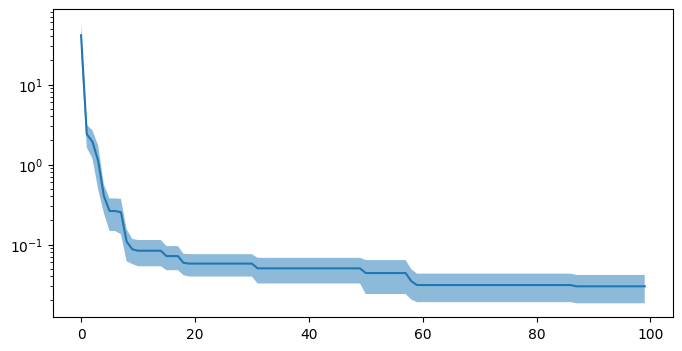

In [11]:
fig = plt.figure(figsize=(8, 4))
plt.fill_between(range(len(reps[0])), reps_mean+0.5*reps_std, reps_mean-0.5*reps_std, alpha=0.5)
plt.plot(range(len(reps[0])), reps_mean)
plt.yscale('log')

<div class="alert alert-success">
    <h3>Exercise 1</h3>
    Study the impact of the $\lambda$ parameter by modifying it and re-running the optimization. What is the best $\lambda$ value for the Himmelblau problem?
</div>

In [25]:
f = lambda x : himmelblau(x[0], x[1])
reps = []
for i in range(5):
    x = np.random.rand(2)*10-5
    reps += [oneplus_lambda(x, f, lam = 30)]
reps = np.array(reps)
reps_mean = np.mean(reps, 0)
reps_std = np.std(reps, 0)

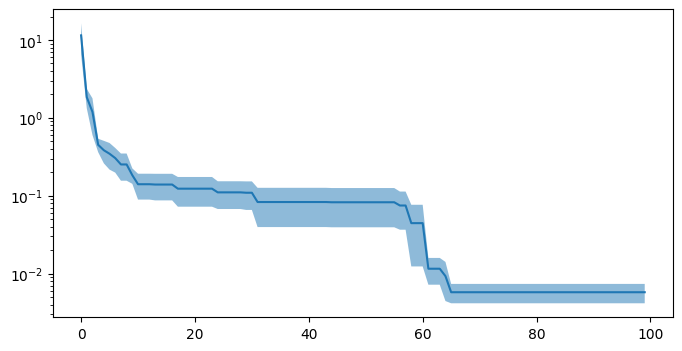

In [26]:
fig = plt.figure(figsize=(8, 4))
plt.fill_between(range(len(reps[0])), reps_mean+0.5*reps_std, reps_mean-0.5*reps_std, alpha=0.5)
plt.plot(range(len(reps[0])), reps_mean)
plt.yscale('log')

In [43]:
f = lambda x : himmelblau(x[0], x[1])
reps = []
for i in range(5):
    x = np.random.rand(2)*10-5
    reps += [oneplus_lambda(x, f, lam = 25)]
reps = np.array(reps)
reps_mean = np.mean(reps, 0)
reps_std = np.std(reps, 0)

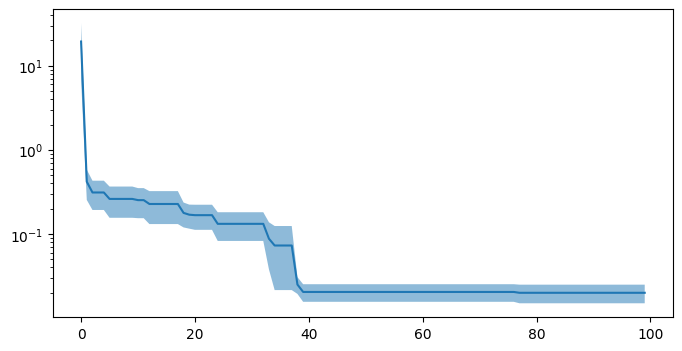

In [44]:
fig = plt.figure(figsize=(8, 4))
plt.fill_between(range(len(reps[0])), reps_mean+0.5*reps_std, reps_mean-0.5*reps_std, alpha=0.5)
plt.plot(range(len(reps[0])), reps_mean)
plt.yscale('log')

In [45]:
f = lambda x : himmelblau(x[0], x[1])
reps = []
for i in range(5):
    x = np.random.rand(2)*10-5
    reps += [oneplus_lambda(x, f, lam = 28)]
reps = np.array(reps)
reps_mean = np.mean(reps, 0)
reps_std = np.std(reps, 0)

$𝜆 = 28$ is a decent choice for the Himmelblau problem

<div class="alert alert-success">
    <h3>Exercise 2</h3>
    Change to the Rosenbrock problem. What is the difficulty of this search space, compared to Himmelblau? Can you find a $\lambda$ parameter adapted to this search space?
</div>

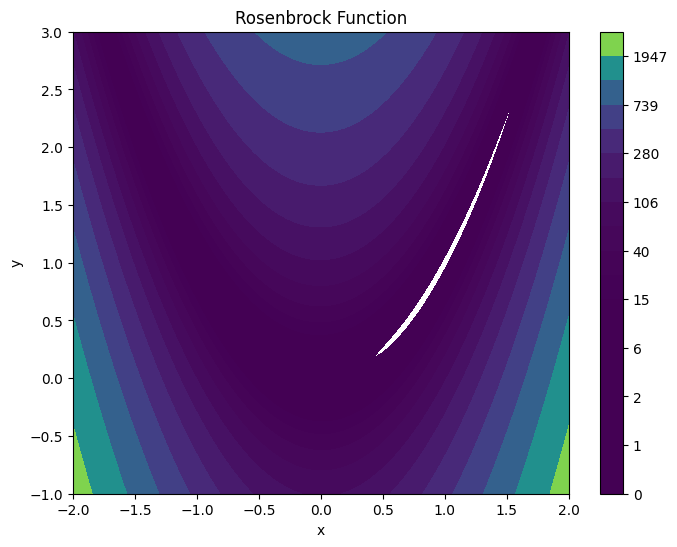

In [51]:
x, y = np.meshgrid(np.linspace(-2, 2, 400), np.linspace(-1, 3, 400))
z = rosenbrock(x, y)

# Plot the Rosenbrock function
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
contour = ax.contourf(x, y, z, levels=np.logspace(-0.5, 3.5, 20), cmap='viridis')
plt.colorbar(contour)
# ax.plot(1, 1, 'r+', mew=2, markersize=10)  # Mark the minimum

ax.set_title('Rosenbrock Function')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

In [52]:
ff = lambda x : rosenbrock(x[0], x[1])
reps = []
for i in range(5):
    x = np.random.rand(2)*10-5
    reps += [oneplus_lambda(x, ff)]
reps = np.array(reps)
reps_mean = np.mean(reps, 0)
reps_std = np.std(reps, 0)

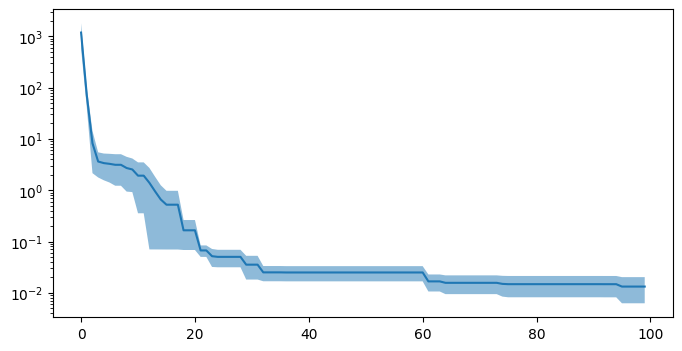

In [53]:
fig = plt.figure(figsize=(8, 4))
plt.fill_between(range(len(reps[0])), reps_mean+0.5*reps_std, reps_mean-0.5*reps_std, alpha=0.5)
plt.plot(range(len(reps[0])), reps_mean)
plt.yscale('log')

# Approximating the gradient

In the $(1+\lambda)$ ES, we move from the best point in a population to the best point in the next randomly sampled population. However, with the population information, we can do better than that; we can move in the direction of the gradient approximated by the fitness values of the population. This makes better use of the full population information by combining all fitness information instead of selecting the best fitness value.

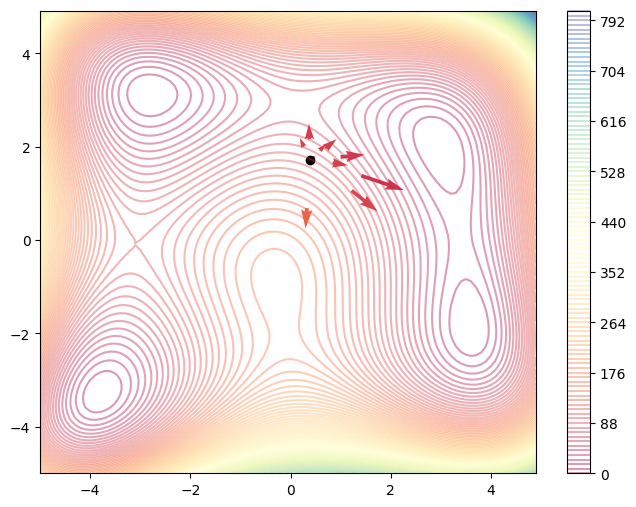

In [12]:
x = np.copy(x_orig)
x_t = np.array([x + np.random.normal(size=(2,))*0.5 for i in range(10)])
fits = himmelblau(x_t[:, 0], x_t[:, 1])
fig = plt.figure(figsize=(8, 6))
norm = colors.Normalize(vmin=Z.min(), vmax=Z.max())
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
plt.quiver(x_t[:, 0], x_t[:, 1], x_t[:, 0]-x[0], x_t[:, 1]-x[1],
           fits, scale=fits/60, scale_units='xy', cmap='Spectral', norm=norm)
plt.scatter(x[0], x[1], c='k')
fig.colorbar(cs)
plt.show()

Instead of directly using the fitness values $f$, we will normalize all fitness values by the average $\mu(f(x))$ and standard deviation $\sigma(f(x))$ of the population.

$A = \frac{f(x) - \mu(f(x))}{\sigma(f(x))}$

We'll then define a vector at each point, $x_i - x$.

$N_i = x_i - x$

We multiply $A$ by all individual vectors which scales the vector magnitude by the relative fitness. Finally, we sum all vectors and divide by $\lambda$ to get the weighted average.

$\frac{1}{\lambda}\sum_i A_i N_i$

This is equivalent to the dot product and is used as our gradient approximation. Since we're minimizing, we'll use the negative value to do gradient descent.

$\nabla f \approx -\frac{A \cdot N}{\lambda}$

In [13]:
λ = 10
A = (fits - np.mean(fits)) / np.std(fits)
N = x_t - x
G = -np.dot(A, N) / λ

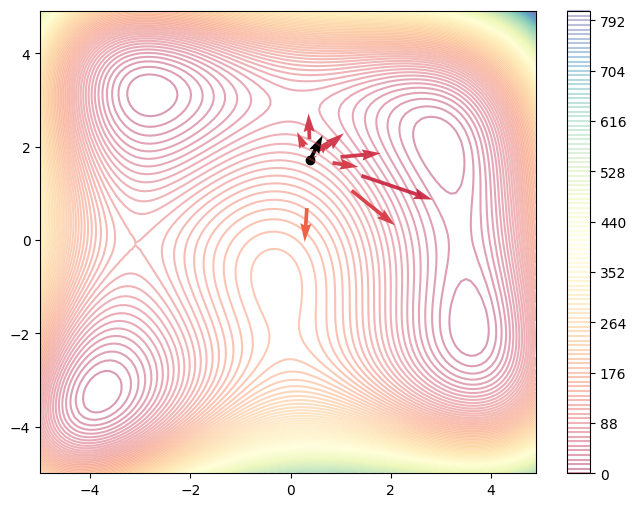

In [14]:
fig = plt.figure(figsize=(8, 6))
norm = colors.Normalize(vmin=Z.min(), vmax=Z.max())
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
plt.quiver(x_t[:, 0], x_t[:, 1], x_t[:, 0]-x[0], x_t[:, 1]-x[1],
           fits, scale=fits/100, scale_units='xy', cmap='Spectral', norm=norm)
plt.quiver(x[0], x[1], G[0], G[1])
plt.scatter(x[0], x[1], c='k')
fig.colorbar(cs)
plt.show()

We have our approximate gradient direction, but how far should we move in it? We'll define a learning rate variable $\alpha$ as the fixed magnitude of movement for now, so our update of $x$ is then

$x = x - \alpha\frac{A \cdot N}{\lambda}$

Let's put this all together as an Evolutionary Strategy. It is a $(\mu, \lambda)$ ES as multiple individuals $\mu$ inform the next generation; however, these individuals are not kept for the next generation.

    Initialize x randomly in ℝ
    while not terminate
        for i in [1,λ]
            N_i = 𝑁(0, 1)
            F_i = f(x + N_i)
        A = (F−𝜇(F))/𝜎(F)
        x = x - 𝛼(A⋅N)/𝜆

In [15]:
def mu_lambda(x, fitness, gens=200, lam=10, alpha=0.2, verbose=False):
    x_best = x
    f_best = fitness(x)
    fits = np.zeros(gens)
    for g in range(gens):
        N = np.random.normal(size=(lam, len(x)))
        F = np.zeros(lam)
        for i in range(lam):
            ind = x + N[i, :]
            F[i] = fitness(ind)
            if F[i] < f_best:
                f_best = F[i]
                x_best = ind
                if verbose:
                    print(g, " ", f_best)
        fits[g] = f_best
        mu_f = np.mean(F)
        std_f = np.std(F)
        A = F
        if std_f != 0:
            A = (F - mu_f) / std_f
        x = x - alpha * np.dot(A, N) / lam
    return fits, x_best

In [16]:
reps = []
for i in range(5):
    x = np.random.randn(2)
    fits, _ = mu_lambda(x, f)
    reps += [fits]
reps = np.array(reps)
reps_mean = np.mean(reps, 0)
reps_std = np.std(reps, 0)

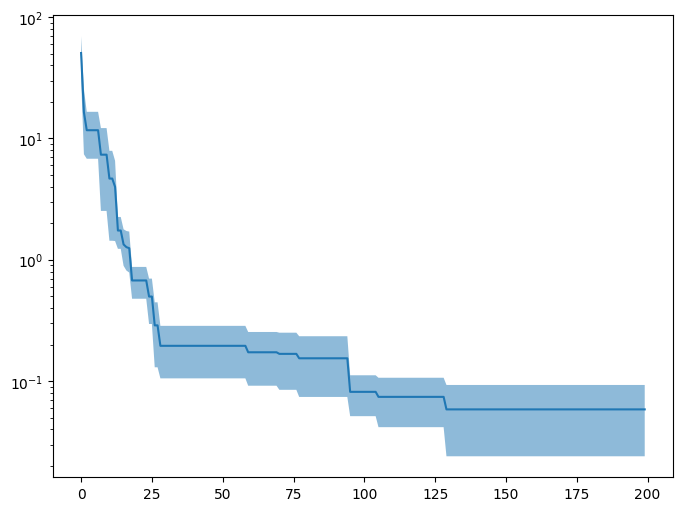

In [17]:
fig = plt.figure(figsize=(8, 6))
plt.fill_between(range(len(reps[0])), reps_mean+0.5*reps_std, reps_mean-0.5*reps_std, alpha=0.5)
plt.plot(range(len(reps[0])), reps_mean)
plt.yscale('log')

<div class="alert alert-success">
    <h3>Exercise 3</h3>
    
Study the impact of the $\alpha$ parameter by modifying it and re-running the optimization. Compare the best parameters found with the results from the $(1+\lambda)$ ES.
</div>

<div class="alert alert-success">
    <h3>Exercise 4</h3>
    
Study the performance of the $(\mu, \lambda)$ ES on the Rastrigin function. Does it perform better or worse than the  $(1+\lambda)$ ES?
</div>

# Rank-based update

We can make two observations about our current $(\mu, \lambda)$ Evolutionary Strategy:

1. Not all $\lambda$ points may be useful for the centroid update
2. Exact gradient information may be noisier than relative *rank* of individual fitness

Let's illustrate this point in the Himmelblau function. Instead of using all $\lambda$ points, we'll use a smaller value of $\mu$, for example $\frac{1}{2}\lambda$. We'll also create a list of weights which exponentially decreases from the first to last weight.

In [18]:
mu = 5
w = np.log(mu + 1/2) - np.log(np.arange(1, mu+1))
w /= np.sum(w)
w

array([0.45627265, 0.2707531 , 0.16223112, 0.08523355, 0.02550959])

As before, we create a random starting point and then add Gaussian noise to create offspring.

In [19]:
x = np.copy(x_orig)
N = np.random.normal(size=(10,2))*0.5
x_t = x + N
fits = himmelblau(x_t[:, 0], x_t[:, 1])
fits

array([ 79.93877244, 133.68559837,  75.2808306 ,  94.75788328,
       127.33857972,  60.09703655,  79.95170511,  90.13354902,
        88.21013666,  98.32629079])

Now, however, instead of directly using fitness values, we'll select the best individuals and update using their weighted values.

In [20]:
sorted_ids = np.argsort(fits)
weighted = N[sorted_ids[:mu]] * w.reshape(mu, 1)
weighted

array([[-0.45870036,  0.55267986],
       [ 0.14056655,  0.04304095],
       [ 0.0464855 ,  0.03808047],
       [-0.06269466,  0.04448584],
       [-0.00275774,  0.00630307]])

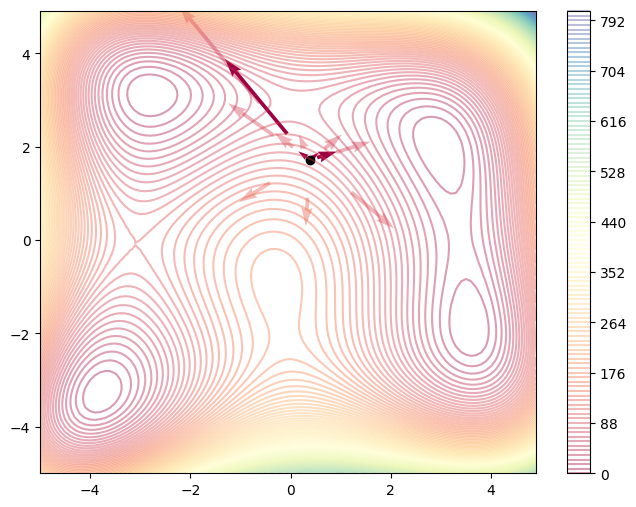

In [21]:
fig = plt.figure(figsize=(8, 6))
norm = colors.Normalize(vmin=Z.min(), vmax=Z.max())
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
plt.quiver(x_t[:, 0], x_t[:, 1], x_t[:, 0]-x[0], x_t[:, 1]-x[1],
           fits, scale=fits/100, scale_units='xy', cmap='Spectral', norm=norm, alpha=0.4)
plt.quiver(x[0]+weighted[:, 0], x[1]+weighted[:, 1], weighted[:, 0], weighted[:, 1],
           w, scale_units='xy', cmap='Spectral', norm=norm)
plt.scatter(x[0], x[1], c='k')
fig.colorbar(cs)
plt.show()

The first point is clear: using all points in the centroid update could pull it away from nearby optima. The second point is a bit harder to understand, but motivation is this: any transformation to the search space which **preserves rank** for the top $\mu$ individuals does not change the update. This invariance property is helpful to search because it increases the predictive power of the fitness by inducing problem equivalence classes.

Hansen, N., Ros, R., Mauny, N., Schoenauer, M., & Auger, A. (2011). Impacts of invariance in search: When CMA-ES and PSO face ill-conditioned and non-separable problems. Applied Soft Computing, 11(8), 5755-5769.

Incorporating these two changes to the previous $(\mu, \lambda)$ ES brings us an ES referred to as Canonical ES:

<img src="https://github.com/d9w/evolution/raw/master/imgs/canonical.png" width="40%" height="auto">

Chrabaszcz, P., Loshchilov, I., & Hutter, F. (2018, July). Back to basics: benchmarking canonical evolution strategies for playing Atari. In Proceedings of the 27th International Joint Conference on Artificial Intelligence (pp. 1419-1426). [code](https://github.com/PatrykChrabaszcz/Canonical_ES_Atari)

<img src="https://github.com/d9w/evolution/raw/master/imgs/canonical_results.png" width="80%" height="auto">

<div class="alert alert-success">
    <h3>Exercise 5</h3>
    
Consider the Rosenbrock function. How do you expect the gradient rankings to compare to the gradient information? Will they be very similar or different? Plot a sample to investigate.
</div>